In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_validate, KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.inspection import PartialDependenceDisplay


from lightgbm import LGBMClassifier

from sklearn.neural_network import MLPClassifier


In [2]:
df_heart = pd.read_csv('https://tinyurl.com/heartdiseaseprocessed')
df_heart_num = pd.read_csv('https://tinyurl.com/heartdiseaseprocessednumeric')

# convert appropriate features to categorical
for col in df_heart.select_dtypes(include='object').columns:
    df_heart[col] = df_heart[col].astype('category')

X = df_heart_num.drop(columns=['heart_disease']).to_numpy()
y = df_heart_num['heart_disease'].to_numpy()

In [3]:
prevalence = np.mean(y)
majority = np.max([prevalence, 1 - prevalence])

## Penalized Linear Models/Elastic Net

In [4]:
model_elastic = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.5,
    random_state=42,
    max_iter=10000,
    verbose=False,
)

# use cross-validation to estimate performance
cv_elastic = cross_validate(
    model_elastic,
    X,
    y,
    cv=5,
    scoring='accuracy',
)

In [5]:
print(
    'Training accuracy: ',
    np.round(cv_elastic['test_score'].mean(), 3),
    '\nGuessing: ',
    np.round(majority, 3),
)

Training accuracy:  0.828 
Guessing:  0.539


## Tree-based Models

In [6]:
model_boost = LGBMClassifier(
    n_estimators = 1000,
    learning_rate = 1e-3,
    max_depth = 5,
    verbose = -1,
    random_state=42,
)

model_boost_cv = cross_validate(
    model_boost,
    df_heart.drop(columns='heart_disease'),
    df_heart['heart_disease'],
    cv = 5,
    scoring='accuracy',
)

In [7]:
print(
    'Training accuracy: ',
    np.round(np.mean(model_boost_cv['test_score']), 3),
    '\nGuessing: ',
    np.round(majority, 3),
)

Training accuracy:  0.835 
Guessing:  0.539


## Deep Learning Example

In [8]:
model_mlp = MLPClassifier(
    hidden_layer_sizes = (200, 200, 200),  
    learning_rate = 'adaptive',
    learning_rate_init = 0.001,
    shuffle = True,
    random_state = 123,
    warm_start = True,
    nesterovs_momentum = True,
    validation_fraction =  .2,
    verbose = False,
)

# with the above settings, this will take a few seconds
model_mlp_cv = cross_validate(
    model_mlp, 
    X, 
    y, 
    cv = 5
) 

In [9]:
print(
    'Training accuracy: ',
    np.round(np.mean(model_mlp_cv['test_score']), 3),
    '\nGuessing: ',
    np.round(majority, 3),
)

Training accuracy:  0.818 
Guessing:  0.539


## A Tuned Example

In [20]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score

from lightgbm import LGBMClassifier

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df_heart.drop(columns='heart_disease'), 
    df_heart_num['heart_disease'],
    test_size = 0.2,
    random_state = 42
)

model_boost = LGBMClassifier(
    verbose = -1
)

param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [1e-3, 1e-2, 1e-1],
    'max_depth': [3, 5, 7, 9],
    'min_child_samples': [1, 5, 10],
}

# this will take a few seconds
model_boost_cv_tune = RandomizedSearchCV(
    model_boost, 
    param_grid, 
    n_iter = 10,
    cv = 5, 
    scoring = 'accuracy', 
    n_jobs = -1
)

model_boost_cv_tune.fit(X_train, y_train)

test_predictions = model_boost_cv_tune.predict(X_test)
accuracy_score(y_test, test_predictions)

0.85

## Interpretation and Feature Importance

In [24]:
best_model.feature_importances_

array([5891, 1399,    0, 2667, 3380,  626,  832, 4216,  729, 2219,  387,
       1117, 1044], dtype=int32)

In [26]:
best_model = model_boost_cv_tune.best_estimator_
best_model.feature_importances_

# you remember which feature is which, right? if not, do this:
pd.DataFrame({
    'Feature': best_model.feature_name_,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

,Feature,Importance
0,age,2744
7,max_heart_rate,2276
4,cholesterol,2137
9,st_depression,1592
3,resting_bp,1178
11,num_major_vessels,907
12,thalassemia,817
6,resting_ecg,585
1,male,493
10,slope,357


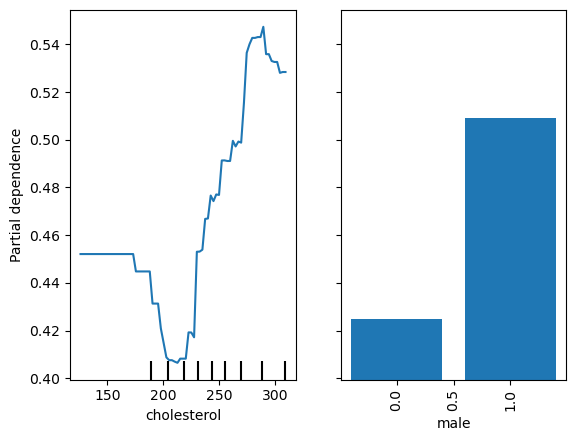

In [34]:
PartialDependenceDisplay.from_estimator(
    model_boost_cv_tune, 
    df_heart.drop(columns='heart_disease'), 
    features=['cholesterol', 'male'], 
    categorical_features=['male'], 
    percentiles=(0, .9),
    grid_resolution=75
)